In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [2]:
train = pd.read_csv('train.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


As it can be seen, there are several missing data points. Specifically, in age and cabin. 

Since, we need to predict the 'Survived' column based on other columns, we will need as much data as possible. Steps to do this:

1. See correlation between survived and other columns
2. Combine train and test dataset
3. Extract titles from names
4. Fill in missing age data from averages of corresponding titles
5. Convert data to categorical variables
6. Normalize data to be between 0 and 1
7. Separate labels (y) from data
8. Create training and dev sets
9. Set up then neural networks to predict y
10. Create submission file and submit
11. Try Other Models - SVM and Random Forest
12. Average All Predictions

## Step 1: See correlation between survived and other columns

In [5]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

Since PassengerId and name is unique to an individual, there is no relation that can be drawn with 'Survived'. 

However, Pclass, Sex, SibSp, Parch, and Embarked are categorical variables with distinct values that can impact 'Survived'.

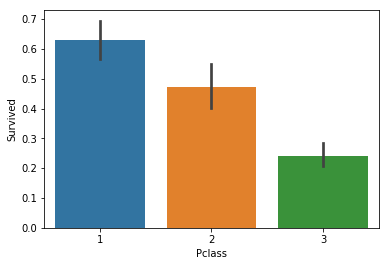

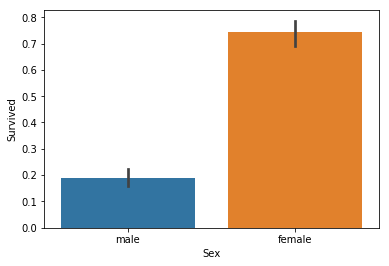

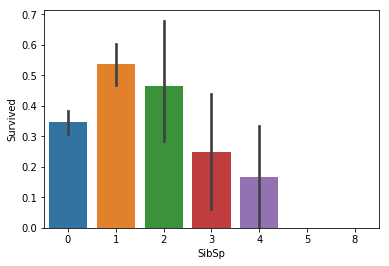

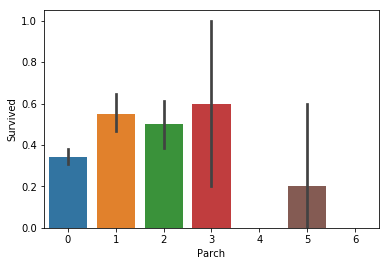

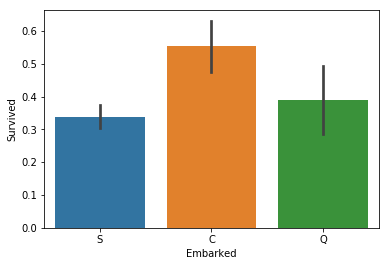

In [6]:
catCols = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
j = 0
for i in catCols:
    plt.figure(j)
    sns.barplot(x = i, y = 'Survived', data = train)
    plt.show()
    j+=1

## Step 2: Combine train and test dataset

In [7]:
test = pd.read_csv('test.csv')

In [8]:
dfs = [train,test]
data = pd.concat(dfs)

In [9]:
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


## Step 3: Extract titles from names

The names begin with certain titles - Master/Miss for children and Mr. / Mrs. for adults. These can be extracted to create a new feature using RegEx

In [10]:
def getTitles(names):
    titleRegex = re.compile(r',.\w+\.')    
    title = []
    for str in names:
        titlePat = re.search(titleRegex,str)
        if titlePat is None:
            title.append(str)
        else:
            x = titlePat.group()
            x = x[2:len(x)-1]
            title.append(x)
    return title


title = getTitles(data['Name'])

In [11]:
set(title)

{'Capt',
 'Col',
 'Don',
 'Dona',
 'Dr',
 'Jonkheer',
 'Lady',
 'Major',
 'Master',
 'Miss',
 'Mlle',
 'Mme',
 'Mr',
 'Mrs',
 'Ms',
 'Rev',
 'Rothes, the Countess. of (Lucy Noel Martha Dyer-Edwards)',
 'Sir'}

In [12]:
def getCleanTitles(title):
    for i in range(len(title)):
        if title[i] in ['Capt','Don', 'Rev','Sir']:
            title[i] = 'Mr'
        elif title[i] in ['Mme','Rothes, the Countess. of (Lucy Noel Martha Dyer-Edwards)', 'Lady', 'Dona']:
            title[i] = 'Mrs'
        elif title[i] in ['Mlle', 'Ms']:
            title[i] = 'Miss'
        elif title[i] in ['Dr', 'Jonkheer', 'Col', 'Major']:
            title[i] = 'Other'
    return title

data['Title'] = getCleanTitles(title)

In [13]:
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr


## Step 4: Fill in missing age data from averages of corresponding titles

In [14]:
data.groupby('Title').Age.mean()

Title
Master     5.482642
Miss      21.824366
Mr        32.478885
Mrs       36.971264
Other     46.857143
Name: Age, dtype: float64

In [15]:
data['Age'].fillna(data.groupby('Title')['Age'].transform("mean"), inplace=True)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 13 columns):
Age            1309 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
Title          1309 non-null object
dtypes: float64(3), int64(4), object(6)
memory usage: 143.2+ KB


As it can be seen there are no more NA values in Age. Since Cabin still has several, we will not include it in our list of features.

In [17]:
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr


## Step 5: Convert data to categorical variables

In [18]:
data.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Title'],
      dtype='object')

In [19]:
catCols.append('Title')

In [20]:
set(data.Embarked)

{'C', 'Q', 'S', nan}

In [21]:
data['Embarked'] = data.Embarked.fillna('O')

In [22]:
def convertCatValToNum(catVal):
    le = LabelEncoder()
    le.fit(catVal)
    catVal = le.transform(catVal)
    return catVal


for i in catCols:
    data[i] = convertCatValToNum(data[i])

In [23]:
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,3,7.2500,"Braund, Mr. Owen Harris",0,1,2,1,1,0.0,A/5 21171,2
1,38.0,C85,0,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,0,0,1,1.0,PC 17599,3
2,26.0,NaN,3,7.9250,"Heikkinen, Miss. Laina",0,3,2,0,0,1.0,STON/O2. 3101282,1
3,35.0,C123,3,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,0,0,1,1.0,113803,3
4,35.0,NaN,3,8.0500,"Allen, Mr. William Henry",0,5,2,1,0,0.0,373450,2


## Step 6: Normalize data to be between 0 and 1

In [24]:
data.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Title'],
      dtype='object')

In [25]:
Xcols = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title']

In [26]:
data[Xcols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 8 columns):
Pclass      1309 non-null int64
Sex         1309 non-null int64
Age         1309 non-null float64
SibSp       1309 non-null int64
Parch       1309 non-null int64
Fare        1308 non-null float64
Embarked    1309 non-null int64
Title       1309 non-null int64
dtypes: float64(2), int64(6)
memory usage: 92.0 KB


In [27]:
# Fare still has one missing value. Fill it with the mean

data['Fare'].fillna(data['Fare'].mean(), inplace = True)

In [28]:
scaler = MinMaxScaler()
scaler.fit(data[Xcols])
X = scaler.transform(data[Xcols])

In [29]:
# Check if the features have been correctly scaled

X_stats = pd.DataFrame()
X_stats['Min'] = np.min(X, axis = 0)
X_stats['Max'] = np.max(X, axis = 0)
X_stats['Mean'] = np.mean(X, axis = 0)
X_stats

,Min,Max,Mean
0,0.0,1.0,0.647441
1,0.0,1.0,0.644003
2,0.0,1.0,0.372750
3,0.0,1.0,0.080851
4,0.0,1.0,0.054567
5,0.0,1.0,0.064988
6,0.0,1.0,0.761395
7,0.0,1.0,0.470397


## Step 7: Separate labels (y) from data

In [30]:
m = train.shape[0]
y = data.Survived.values

In [31]:
y = y[range(m)]

In [32]:
y.shape

(891,)

## Step 8: Create training and dev sets

In [33]:
# Set random seed

seed = 5
np.random.seed(seed)

# Get random training index

train_index = np.random.choice(m, round(m*0.9), replace=False)
dev_index = np.array(list(set(range(m)) - set(train_index)))

test_index = range(m, data.shape[0])
# Make training and dev

X_train = X[train_index]
X_dev = X[dev_index]
X_test = X[test_index]

y_train = y[train_index]
y_dev = y[dev_index]


In [34]:
X_test.shape

(418, 8)

## Step 9: Set up neural networks to predict y

In [35]:
# Initialize placeholders for data
n = X.shape[1]
x = tf.placeholder(dtype=tf.float32, shape=[None, n])
y = tf.placeholder(dtype=tf.float32, shape=[None, 1])

In [36]:
# number of neurons in each layer

input_num_units = n
hidden_num_units = 50
output_num_units = 1

In [37]:
# Build Neural Network Weights
initializer = tf.contrib.layers.xavier_initializer()
weights = {
    'hidden1': tf.Variable(initializer([input_num_units, hidden_num_units])),
    'hidden2': tf.Variable(initializer([hidden_num_units, hidden_num_units])),
    'hidden3': tf.Variable(initializer([hidden_num_units, hidden_num_units])),
    'output': tf.Variable(initializer([hidden_num_units, output_num_units])),
}

biases = {
    'hidden1': tf.Variable(initializer([hidden_num_units])),
    'hidden2': tf.Variable(initializer([hidden_num_units])),
    'hidden3': tf.Variable(initializer([hidden_num_units])),
    'output': tf.Variable(initializer([output_num_units])),
}

In [63]:
# Set hyperparameters

learning_rate = 0.02
epochs = 2000

In [39]:
# Build model 

hidden_1_layer = tf.add(tf.matmul(x, weights['hidden1']), biases['hidden1'])
hidden_1_layer = tf.nn.dropout(tf.nn.relu(hidden_1_layer),keep_prob = 0.7)
hidden_2_layer = tf.add(tf.matmul(hidden_1_layer, weights['hidden2']), biases['hidden2'])
hidden_2_layer = tf.nn.dropout(tf.nn.relu(hidden_2_layer),keep_prob = 0.7)
hidden_3_layer = tf.add(tf.matmul(hidden_2_layer, weights['hidden2']), biases['hidden2'])
hidden_3_layer = tf.nn.dropout(tf.nn.relu(hidden_3_layer),keep_prob = 0.7)

output_layer = tf.matmul(hidden_3_layer, weights['output']) + biases['output']


In [40]:
# Set loss function and goal i.e. minimize loss

loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=output_layer, labels=y))
opt = tf.train.AdamOptimizer(learning_rate)
goal = opt.minimize(loss)

In [41]:
prediction = tf.round(tf.nn.sigmoid(output_layer))
correct = tf.cast(tf.equal(prediction, y), dtype=tf.float32)
accuracy = tf.reduce_mean(correct)

In [42]:
# Initialize lists to store loss and accuracy while training the model

loss_trace = []
train_acc = []
dev_acc = []

In [64]:
# Start tensorflow session

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [66]:
# training model


for epoch in range(epochs):
    sess.run(goal, feed_dict={x: X_train, y: np.matrix(y_train).T})
    
    # calculate results for epoch
    
    temp_loss = sess.run(loss, feed_dict={x: X_train, y: np.matrix(y_train).T})
    temp_train_acc = sess.run(accuracy, feed_dict={x: X_train, y: np.matrix(y_train).T})
    temp_dev_acc = sess.run(accuracy, feed_dict={x: X_dev, y: np.matrix(y_dev).T})
    
    # save results in a list
    
    loss_trace.append(temp_loss)
    train_acc.append(temp_train_acc)
    dev_acc.append(temp_dev_acc)
    
    # output
    
    if (epoch + 1) % 200 == 0:
        print('epoch: {:4d} loss: {:5f} train_acc: {:5f} dev_acc: {:5f}'.format(epoch + 1, temp_loss,
                                                                          temp_train_acc, temp_dev_acc))

epoch:  200 loss: 0.287293 train_acc: 0.866584 dev_acc: 0.775281
epoch:  400 loss: 0.287296 train_acc: 0.869077 dev_acc: 0.775281
epoch:  600 loss: 0.277908 train_acc: 0.871571 dev_acc: 0.764045
epoch:  800 loss: 0.289805 train_acc: 0.877805 dev_acc: 0.764045
epoch: 1000 loss: 0.284961 train_acc: 0.881546 dev_acc: 0.764045
epoch: 1200 loss: 0.290947 train_acc: 0.876559 dev_acc: 0.786517
epoch: 1400 loss: 0.294755 train_acc: 0.871571 dev_acc: 0.808989
epoch: 1600 loss: 0.295191 train_acc: 0.875312 dev_acc: 0.775281
epoch: 1800 loss: 0.289676 train_acc: 0.879052 dev_acc: 0.764045
epoch: 2000 loss: 0.293583 train_acc: 0.876559 dev_acc: 0.786517


## Step 10: Create submission file and submit

In [67]:
y_preds_nn = sess.run(prediction, feed_dict ={x: X_test})

In [68]:
sess.close()

In [69]:
test['Survived_nn'] = y_preds_nn.astype(int)

In [70]:
test[['PassengerId', 'Survived_nn']].to_csv('submission_nn.csv', index = False, header = ['PassengerId', 'Survived'])

# Step 11: Try Other Models - SVM and Random Forest

In [49]:
svclassifier = SVC()
svclassifier.fit(X_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [50]:
y_dev_svm = svclassifier.predict(X_dev)
dev_acc_svm = np.mean(y_dev == y_dev_svm)
print('Dev Accuracy for SVM: {:5f}'.format(dev_acc_svm))

Dev Accuracy for SVM: 0.707865


In [51]:
y_preds_svm = svclassifier.predict(X_test)

In [52]:
test['Survived_svm'] = y_preds_svm.astype(int)

In [53]:
test[['PassengerId', 'Survived_svm']].to_csv('submission_svm.csv', index = False, header = ['PassengerId', 'Survived'])

In [54]:
rfclassifier = RandomForestClassifier(n_estimators = 1000, max_features = 3)
rfclassifier.fit(X_train, y_train) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [55]:
y_dev_rf = rfclassifier.predict(X_dev)
dev_acc_rf = np.mean(y_dev == y_dev_rf)
print('Dev Accuracy for Random Forest: {:5f}'.format(dev_acc_rf))

Dev Accuracy for Random Forest: 0.786517


In [56]:
y_preds_rf = rfclassifier.predict(X_test)

In [57]:
test['Survived_rf'] = y_preds_rf.astype(int)

In [58]:
test[['PassengerId', 'Survived_rf']].to_csv('submission_rf.csv', index = False, header = ['PassengerId', 'Survived'])

# Step 12: Average All Predictions

In [59]:
test.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Survived_nn', 'Survived_svm',
       'Survived_rf'],
      dtype='object')

In [71]:
y_preds_avg = np.round(np.mean(test[['Survived_nn', 'Survived_svm','Survived_rf']],axis = 1))

In [72]:
test['Survived_avg'] = y_preds_avg.astype(int)

In [73]:
test[['PassengerId', 'Survived_avg']].to_csv('submission_avg.csv', index = False, header = ['PassengerId', 'Survived'])